In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools
using LaTeXStrings

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [3]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
omega = 180.
modes = [Mode(omega, 2.0 * omega * HR)]

mols = [
        Molecule(modes, 3, [0., 200.]),
        Molecule(modes, 3, [0., 400.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 200
    aggCore.coupling[mol_i+1, mol_i] = 200
end
agg = setupAggregate(aggCore)
agg.tools.bSize

27

In [4]:
tspan = get_tspan(0., 0.01, 200)
W0, rho0, W0_bath = ultrafast_laser_excitation(10., [0.8, 0.2], agg)
println("")

In [5]:
@time _, rho_int_t1 = QME_sI_ansatz_test(
    W0,
    tspan,
    agg;
    reltol = 1e-9,
    abstol = 1e-9,
    int_reltol = 1e-10,
    int_abstol = 1e-10,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)
println("")

 39.762957 seconds (99.83 M allocations: 7.780 GiB, 6.12% gc time)



In [6]:
@time _, rho_int_t2 = QME_sI_ansatz_const(
    W0,
    tspan,
    agg;
    reltol = 1e-9,
    abstol = 1e-9,
    int_reltol = 1e-10,
    int_abstol = 1e-10,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)
println("")

 14.115344 seconds (29.18 M allocations: 2.856 GiB, 4.55% gc time, 3.16% compilation time)



In [7]:
@time _, rho_int_t3 = QME_sI_ansatz_upart1(
    W0,
    tspan,
    agg;
    reltol = 1e-9,
    abstol = 1e-9,
    int_reltol = 1e-10,
    int_abstol = 1e-10,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)
println("")

 15.146601 seconds (27.78 M allocations: 3.088 GiB, 3.43% gc time, 1.57% compilation time)



In [8]:
@time _, rho_int_t0 = Evolution_sI_exact(W0, tspan, agg)
println("")

  0.634158 seconds (919.02 k allocations: 129.647 MiB, 3.63% gc time)



In [9]:
rho_int_t0 = operator_recast(rho_int_t0)
rho_int_t1 = operator_recast(rho_int_t1)
rho_int_t2 = operator_recast(rho_int_t2)
rho_int_t3 = operator_recast(rho_int_t3)
println("")

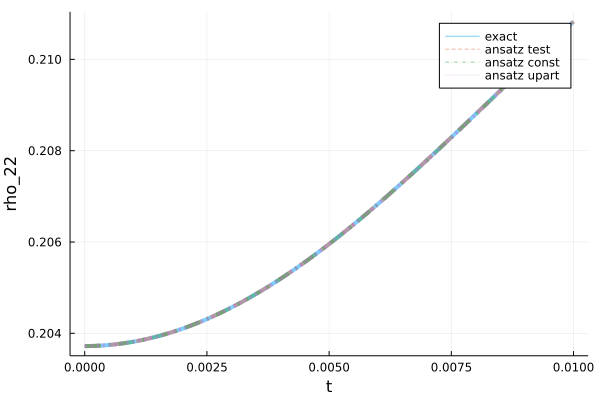

In [19]:
n, m = 2, 2
plot(tspan, real(rho_int_t0[:, n, m]), label="exact", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_int_t1[:, n, m]), label="ansatz test", linealpha = 0.5, linewidth = 4, linestyle = :dash)
plot!(tspan, real(rho_int_t2[:, n, m]), label="ansatz const", linealpha = 0.5, linewidth = 4, linestyle = :dashdot)
plotd = plot!(tspan, real(rho_int_t3[:, n, m]), label="ansatz upart", linealpha = 0.5, linewidth = 4, linestyle = :dot,
    ylabel = "rho_$(n)$(m)", xlabel = "t")
savefig(plotd,"C:/Users/daniel.herman/Documents/Mgr/OpenQuantumSystems/workbench/2021-12-16 seminár Kopecký/img/rho_int_$(n)$(m).png")
plotd

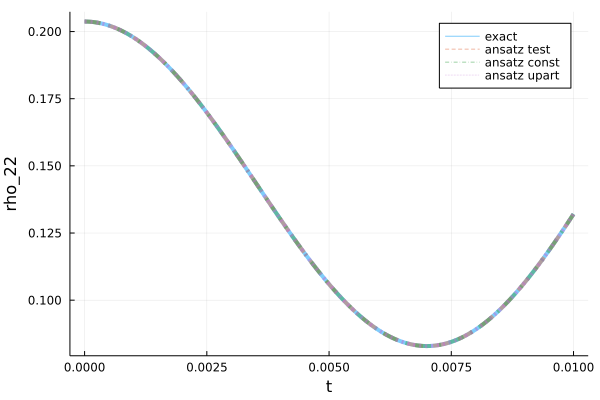

In [20]:
rho_t0 = interaction_pic_to_schroedinger_pic(rho_int_t0, tspan, agg)
rho_t1 = interaction_pic_to_schroedinger_pic(rho_int_t1, tspan, agg)
rho_t2 = interaction_pic_to_schroedinger_pic(rho_int_t2, tspan, agg)
rho_t3 = interaction_pic_to_schroedinger_pic(rho_int_t3, tspan, agg)

n, m = 2, 2
plot(tspan, real(rho_t0[:, n, m]), label="exact", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t1[:, n, m]), label="ansatz test", linealpha = 0.5, linewidth = 4, linestyle = :dash)
plot!(tspan, real(rho_t2[:, n, m]), label="ansatz const", linealpha = 0.5, linewidth = 4, linestyle = :dashdot)
plotd = plot!(tspan, real(rho_t3[:, n, m]), label="ansatz upart", linealpha = 0.5, linewidth = 4, linestyle = :dot,
    ylabel = "rho_$(n)$(m)", xlabel = "t")
savefig(plotd,"C:/Users/daniel.herman/Documents/Mgr/OpenQuantumSystems/workbench/2021-12-16 seminár Kopecký/img/rho_sch_$(n)$(m).png")
plotd

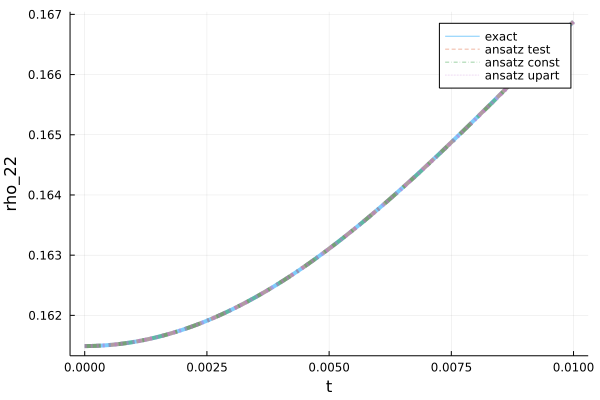

In [21]:
using OpenQuantumSystems
rho_t0_exc = local_st_to_exciton_st(rho_t0, agg)
rho_t1_exc = local_st_to_exciton_st(rho_t1, agg)
rho_t2_exc = local_st_to_exciton_st(rho_t2, agg)
rho_t3_exc = local_st_to_exciton_st(rho_t3, agg)

n, m = 2, 2
plot(tspan, real(rho_t0_exc[:, n, m]), label="exact", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t1_exc[:, n, m]), label="ansatz test", linealpha = 0.5, linewidth = 4, linestyle = :dash)
plot!(tspan, real(rho_t2_exc[:, n, m]), label="ansatz const", linealpha = 0.5, linewidth = 4, linestyle = :dashdot)
plotd = plot!(tspan, real(rho_t3_exc[:, n, m]), label="ansatz upart", linealpha = 0.5, linewidth = 4, linestyle = :dot,
    ylabel = "rho_$(n)$(m)", xlabel = "t")
savefig(plotd,"C:/Users/daniel.herman/Documents/Mgr/OpenQuantumSystems/workbench/2021-12-16 seminár Kopecký/img/rho_exc_22.png")
plotd

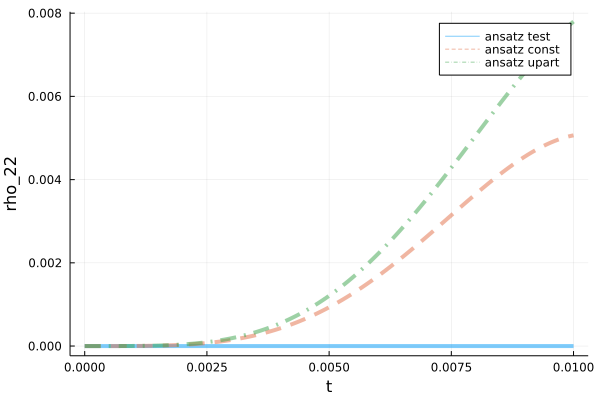

In [22]:
rho_t1_rel = compare_rho_in_time(rho_int_t1, rho_int_t0) * 100
rho_t2_rel = compare_rho_in_time(rho_int_t2, rho_int_t0) * 100
rho_t3_rel = compare_rho_in_time(rho_int_t3, rho_int_t0) * 100

plot(tspan, real(rho_t1_rel[:, n, m]), label="ansatz test", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t2_rel[:, n, m]), label="ansatz const", linealpha = 0.5, linewidth = 4, linestyle = :dash)
plotd = plot!(tspan, real(rho_t3_rel[:, n, m]), label="ansatz upart", linealpha = 0.5, linewidth = 4, linestyle = :dashdot,
    ylabel = "rho_$(n)$(m)", xlabel = "t")
savefig(plotd,"C:/Users/daniel.herman/Documents/Mgr/OpenQuantumSystems/workbench/2021-12-16 seminár Kopecký/img/rho_rel_22.png")
plotd

In [33]:
score_1 = compare_rho(rho_int_t1, rho_int_t0) * 100
score_2 = compare_rho(rho_int_t2, rho_int_t0) * 100
score_3 = compare_rho(rho_int_t3, rho_int_t0) * 100

3×3 Matrix{Float64}:
 0.0  0.0        0.0
 0.0  0.0023263  0.280095
 0.0  0.280095   0.00627674

In [34]:
score_1

3×3 Matrix{Float64}:
 0.0  0.0         0.0
 0.0  5.4081e-8   3.55957e-5
 0.0  3.55957e-5  6.40832e-8

In [35]:
score_2

3×3 Matrix{Float64}:
 0.0  0.0        0.0
 0.0  0.0016613  0.25138
 0.0  0.25138    0.00557967

In [ ]:
using OpenQuantumSystems
include("test_master_exact.jl")


Test Summary: |
master        | No tests


Test.DefaultTestSet("master", Any[], 0, false, false)

In [ ]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   33     33
Test Summary:       | Pass  Total
interaction picture |   12     12
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
